In [1]:
include("IsingCore.jl")
using .IsingCore
using Logging, LinearAlgebra, Statistics, StatsBase, ProgressMeter
using CairoMakie

println(names(IsingCore))

[:IsingCore, :calc_acceptance_and_rtt, :calc_energy, :initial_state, :metropolis_sampler, :uniform_acceptance_grad_sm]


In [2]:
N = 20
M = 20

20

In [9]:
function run_simulation(N; mcSteps=10^4, eqSteps=10^2)
    total_sites = N * N
    βs = 0.01:0.005:1.05

    E_vals = Float64[]
    M_vals = Float64[]
    Cv_vals = Float64[]
    Chi_vals = Float64[]

    @showprogress for β in βs
        config = IsingCore.initial_state(N)

        for _ in 1:eqSteps
            config = IsingCore.metropolis_sampler(config, β, N)
        end

        E_acc, E2_acc, M_acc, M2_acc = 0.0, 0.0, 0.0, 0.0

        for _ in 1:mcSteps
            config = IsingCore.metropolis_sampler(config, β, N)
            E = IsingCore.calc_energy(config, N)
            M = IsingCore.calc_magnetization(config, N)
            E_acc += E
            E2_acc += E^2
            M_acc += M
            M2_acc += M^2
        end

        avg_E = E_acc / mcSteps
        avg_E2 = E2_acc / mcSteps
        avg_M = M_acc / mcSteps
        avg_M2 = M2_acc / mcSteps

        energy_per_site = avg_E / total_sites
        specific_heat = (avg_E2 - avg_E^2) * β^2 / total_sites
        susceptibility = (avg_M2 - avg_M^2) * total_sites * β
        
        push!(E_vals, energy_per_site)
        push!(M_vals, avg_M)
        push!(Cv_vals, specific_heat)
        push!(Chi_vals, susceptibility)
    end
    
    return βs, E_vals, M_vals, Cv_vals, Chi_vals
end

run_simulation (generic function with 1 method)

In [10]:
βs, energies, magnetizations, specific_heats, susceptibilities = run_simulation(N)
println("Simulation completed.")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


Simulation completed.


In [11]:
dir = "../../plots/Ising_model/L=$N/M=$M"
if dir !== nothing
    mkpath(dir)
end

"../../plots/Ising_model/L=20/M=20"

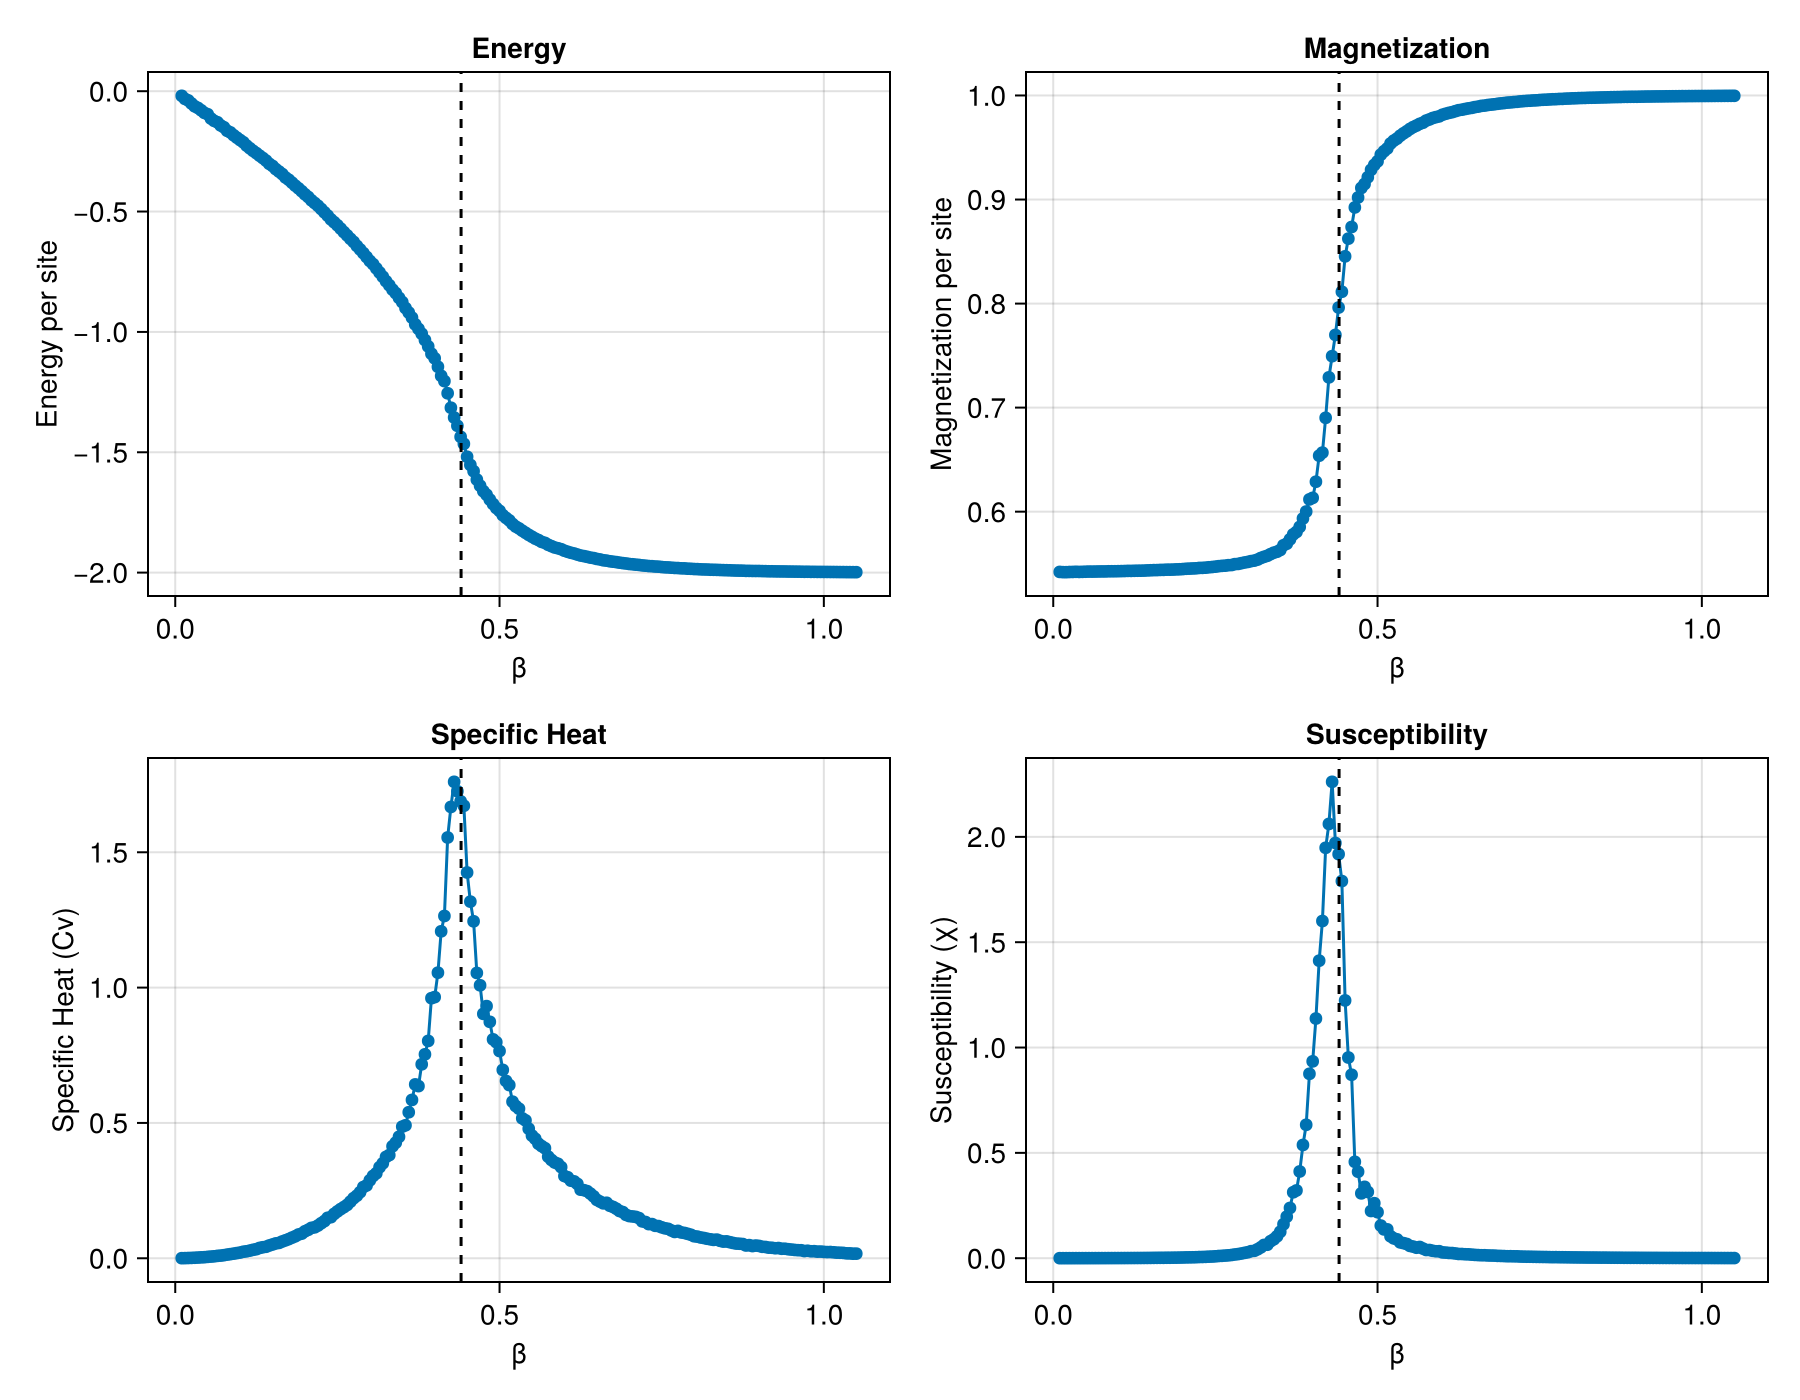

CairoMakie.Screen{IMAGE}


In [12]:
β_c = round(log(1 + sqrt(2)) / 2, digits=4)

fig = Figure(size = (900, 700))
ax1 = Axis(fig[1, 1], xlabel = "β", ylabel = "Energy per site", title = "Energy")
scatterlines!(ax1, βs, energies)
vlines!(ax1, [β_c], color=:black, linestyle=:dash)

ax2 = Axis(fig[1, 2], xlabel = "β", ylabel = "Magnetization per site", title = "Magnetization")
scatterlines!(ax2, βs, magnetizations)
vlines!(ax2, [β_c], color=:black, linestyle=:dash)

ax3 = Axis(fig[2, 1], xlabel = "β", ylabel = "Specific Heat (Cv)", title = "Specific Heat")
scatterlines!(ax3, βs, specific_heats)
vlines!(ax3, [β_c], color=:black, linestyle=:dash)

ax4 = Axis(fig[2, 2], xlabel = "β", ylabel = "Susceptibility (χ)", title = "Susceptibility")
scatterlines!(ax4, βs, susceptibilities)
vlines!(ax4, [β_c], color=:black, linestyle=:dash)

display(fig)

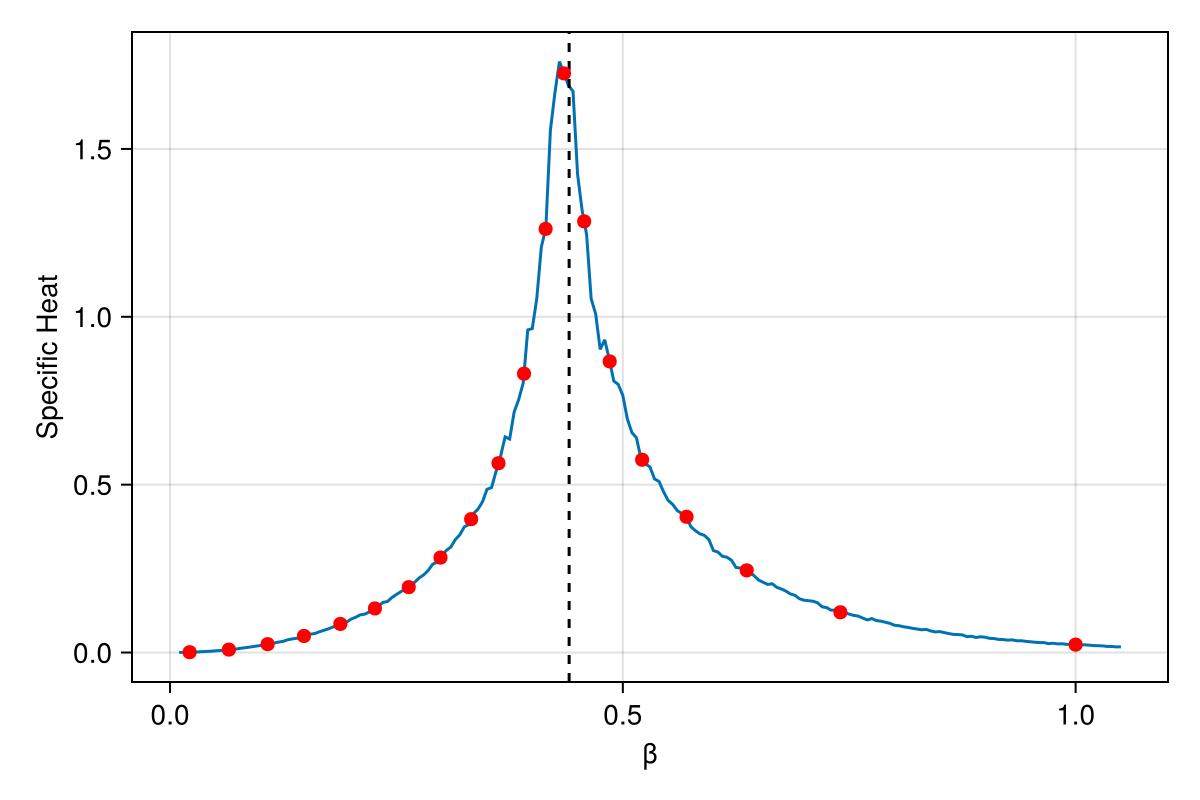

In [13]:
using Interpolations

optimized_β = [0.021659803169800203, 0.06497669315494146, 0.10777151425516149, 0.14790864813022578, 0.18808473371548468, 0.22626297050501248, 0.2635947119913787, 0.29866440457508653, 0.33246668466746104, 0.36269562842167435, 0.39087724457119266, 0.4147510074157761, 0.4350559316829531, 0.4572924523541318, 0.4854927608287761, 0.5213108162541505, 0.5703573187929347, 0.6367974450062208, 0.7402446282121756, 1.0]

itp = linear_interpolation(βs, specific_heats)
optimized_cvs = itp(optimized_β)

fig1 = Figure(size = (600, 400))
ax = Axis(
    fig1[1, 1], 
    xlabel = "β", 
    ylabel = "Specific Heat", 
    # title = "Specific Heat"
)
lines!(ax, βs, specific_heats)
vlines!(ax, [β_c], color=:black, linestyle=:dash)
scatter!(ax, optimized_β, optimized_cvs, color = :red, markersize = 10, label = "Optimized β")
display(fig1)
save("$dir/specific_heats.png", fig1; px_per_unit=4)